In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels
import statsmodels.stats.diagnostic as smd
from statsmodels.formula.api import ols
from statsmodels.compat import lzip
import statsmodels.tools.eval_measures as sme

from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import math
import seaborn as sns
import numpy as np
import pandas as pd
import csv
import import_ipynb
import functions as func

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

importing Jupyter notebook from functions.ipynb


In [2]:
data_1 = pd.read_csv('data/data_1.csv')
data_2 = pd.read_csv('data/data_2.csv')
data_3 = pd.read_csv('data/data_3.csv')
data_4 = pd.read_csv('data/data_4.csv')
data_5 = pd.read_csv('data/data_5.csv')

## select year

In [3]:
data_df = data_3.copy()

In [4]:
predictors_3 = ['WAR', 'RBI', 'wRAA', 'Year_FA', 'Age', '3B', 'BB', '1B_pos', '2B_pos', '3B_pos', 'C_pos',
       'DH_pos', 'SS_pos']
predictors_3_rbi = ['WAR', 'RBI', 'RBI_2', 'wRAA', 'Year_FA', 'Age', '3B', 'BB', '1B_pos', '2B_pos', '3B_pos', 'C_pos',
       'DH_pos', 'SS_pos']
predictors_5 = ['WAR', 'Age', 'Year_FA', '2B', 'wRAA', 'BB', 'HBP', 'RBI', 'SH', '1B_pos', '2B_pos', '3B_pos', 'C_pos',
       'DH_pos', 'SS_pos']

# transform data

In [5]:
data_df['Salary_sqrt'] = data_df['Salary'] ** (1/2)
data_df['RBI_2'] = data_df['RBI'] ** 2

# 5 fold CV

In [6]:
# # function params
# data = data_df.copy()
# predictors = predictors_3_rbi
# response = 'Salary_sqrt'
# num_fold = 5

MSE: 8779117383440.919; RMSE: 2942952.787; RMSPE: 36.578; MEANABS: 2008004.597; MEDIANABS: 1312139.818


/Users/honeybunny/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


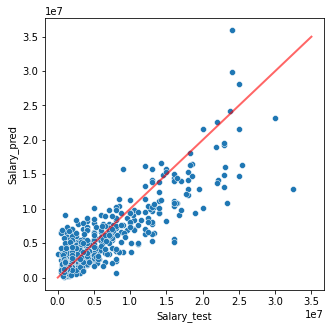

In [7]:
func.model_eval(predictors_3_rbi, 'Salary_sqrt', data=data_df)